In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)


In [2]:
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

x_train = x_train[..., None]
x_test  = x_test[..., None]

noise_factor = 0.4
x_train_noisy = np.clip(x_train + noise_factor*np.random.randn(*x_train.shape), 0, 1)
x_test_noisy  = np.clip(x_test  + noise_factor*np.random.randn(*x_test.shape),  0, 1)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
def build_generator():
    inp = layers.Input(shape=(28,28,1))

    d1 = layers.Conv2D(64, 4, 2, padding="same")(inp)
    d1 = layers.LeakyReLU(0.2)(d1)

    d2 = layers.Conv2D(128, 4, 2, padding="same")(d1)
    d2 = layers.BatchNormalization()(d2)
    d2 = layers.LeakyReLU(0.2)(d2)

    u1 = layers.Conv2DTranspose(128, 4, 2, padding="same")(d2)
    u1 = layers.BatchNormalization()(u1)
    u1 = layers.ReLU()(u1)
    u1 = layers.Concatenate()([u1, d1])

    u2 = layers.Conv2DTranspose(64, 4, 2, padding="same")(u1)
    u2 = layers.BatchNormalization()(u2)
    u2 = layers.ReLU()(u2)

    out = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(u2)

    return models.Model(inp, out)

generator = build_generator()


In [4]:
def build_discriminator():
    noisy = layers.Input(shape=(28,28,1))
    clean = layers.Input(shape=(28,28,1))

    x = layers.Concatenate()([noisy, clean])
    x = layers.Conv2D(64, 4, 2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, 2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    out = layers.Conv2D(1, 3, padding="same", activation="sigmoid")(x)

    return models.Model([noisy, clean], out)

discriminator = build_discriminator()


In [5]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

LAMBDA = 100

gen_optimizer  = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [6]:
@tf.function
def train_step(noisy, clean):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_img = generator(noisy, training=True)

        real_out = discriminator([noisy, clean], training=True)
        fake_out = discriminator([noisy, gen_img], training=True)

        adv_loss = bce(tf.ones_like(fake_out), fake_out)
        l1_loss  = tf.reduce_mean(tf.abs(clean - gen_img))
        gen_loss = adv_loss + LAMBDA * l1_loss

        disc_loss = (
            bce(tf.ones_like(real_out), real_out) +
            bce(tf.zeros_like(fake_out), fake_out)
        )

    gen_grads  = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [7]:
EPOCHS = 120
BATCH = 128

dataset = tf.data.Dataset.from_tensor_slices((x_train_noisy, x_train))
dataset = dataset.shuffle(10000).batch(BATCH)

print("\n--- CONDITIONAL GAN TRAINING STARTED ---\n")

for epoch in range(1, EPOCHS+1):
    for noisy, clean in dataset:
        g_loss, d_loss = train_step(noisy, clean)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{EPOCHS} | G_loss: {g_loss:.2f} | D_loss: {d_loss:.2f}")

print("\n--- TRAINING COMPLETE ---")



--- CONDITIONAL GAN TRAINING STARTED ---

Epoch 10/120 | G_loss: 6.78 | D_loss: 1.16
Epoch 20/120 | G_loss: 6.58 | D_loss: 1.40
Epoch 30/120 | G_loss: 6.62 | D_loss: 1.16
Epoch 40/120 | G_loss: 6.53 | D_loss: 1.22
Epoch 50/120 | G_loss: 6.42 | D_loss: 1.24
Epoch 60/120 | G_loss: 6.62 | D_loss: 1.12
Epoch 70/120 | G_loss: 6.32 | D_loss: 1.30
Epoch 80/120 | G_loss: 6.60 | D_loss: 1.20
Epoch 90/120 | G_loss: 6.10 | D_loss: 1.28
Epoch 100/120 | G_loss: 6.33 | D_loss: 1.28
Epoch 110/120 | G_loss: 6.38 | D_loss: 1.10
Epoch 120/120 | G_loss: 6.15 | D_loss: 1.27

--- TRAINING COMPLETE ---


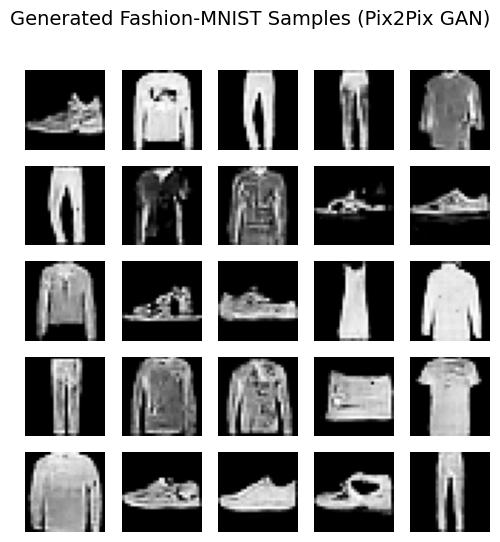

In [8]:
N = 25
gen_imgs = generator.predict(x_test_noisy[:N], verbose=0)

plt.figure(figsize=(6,6))
for i in range(N):
    plt.subplot(5,5,i+1)
    plt.imshow(gen_imgs[i,:,:,0], cmap="gray")
    plt.axis("off")

plt.suptitle("Generated Fashion-MNIST Samples (Pix2Pix GAN)", fontsize=14)
plt.show()


In [16]:
!zip -r GAN_OUTPUT.zip generated_images final_grid.png


  adding: generated_images/ (stored 0%)
  adding: generated_images/gen_76.png (stored 0%)
  adding: generated_images/gen_63.png (stored 0%)
  adding: generated_images/gen_98.png (stored 0%)
  adding: generated_images/gen_33.png (stored 0%)
  adding: generated_images/gen_71.png (stored 0%)
  adding: generated_images/gen_93.png (stored 0%)
  adding: generated_images/gen_70.png (stored 0%)
  adding: generated_images/gen_25.png (stored 0%)
  adding: generated_images/gen_46.png (stored 0%)
  adding: generated_images/gen_37.png (stored 0%)
  adding: generated_images/gen_85.png (stored 0%)
  adding: generated_images/gen_55.png (stored 0%)
  adding: generated_images/gen_4.png (stored 0%)
  adding: generated_images/gen_49.png (stored 0%)
  adding: generated_images/gen_39.png (stored 0%)
  adding: generated_images/gen_42.png (stored 0%)
  adding: generated_images/gen_81.png (stored 0%)
  adding: generated_images/gen_67.png (stored 0%)
  adding: generated_images/gen_90.png (stored 0%)
  adding: g

In [17]:
from google.colab import files
files.download("GAN_OUTPUT.zip")
files.download("final_grid.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>